# import

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns

from datasets import get_ohlcvs, get_closes, get_log_returns

ohlcvs = get_ohlcvs(from_date='2023-01-01', to_date='2023-12-31')
close_prices = get_closes(ohlcvs)
log_returns = get_log_returns(close_prices)

In [2]:
log_returns

,btc,eth,bnb,sol,xrp,ton,doge,ada,trx,wbtc,...,btt,flr,eos,axs,xtz,neo,tkx,frax,dydx,beam
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,0.003372,0.011316,0.003268,0.121447,0.027662,NaN,0.016380,0.015486,0.006547,NaN,...,NaN,NaN,0.003407,0.009434,0.027437,0.020109,0.020109,0.020109,0.036180,-0.009191
2023-01-03,0.000139,0.000453,0.003664,0.169982,-0.013299,NaN,-0.012827,-0.003552,-0.006182,NaN,...,NaN,NaN,-0.002270,0.020140,0.021420,-0.015432,-0.015432,-0.015432,-0.016205,-0.017700
2023-01-04,0.010451,0.034275,0.050704,0.004478,0.010423,NaN,0.036494,0.057246,-0.001095,NaN,...,NaN,NaN,0.030221,0.019742,0.017072,0.024579,0.024579,0.024579,0.013664,0.026891
2023-01-05,-0.001099,-0.004513,-0.008534,0.000000,-0.026855,NaN,-0.021988,0.005214,-0.018985,NaN,...,NaN,NaN,-0.016676,0.017884,-0.007843,-0.010679,-0.010679,-0.010679,0.000000,0.002741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,0.021410,0.064011,0.084966,-0.050877,0.019270,NaN,0.024866,0.039777,0.021979,0.021095,...,NaN,NaN,0.038293,-0.013259,0.059277,0.041984,0.041984,0.041984,0.006581,NaN
2023-12-28,-0.020121,-0.014484,-0.004639,-0.048977,0.000946,NaN,-0.020606,-0.028180,0.001044,-0.018036,...,NaN,NaN,-0.039442,-0.067967,-0.054517,-0.050743,-0.050743,-0.050743,-0.054531,NaN
2023-12-29,-0.011741,-0.019362,-0.027976,0.042031,-0.018448,NaN,-0.008429,-0.012254,0.001421,-0.014223,...,NaN,NaN,-0.026793,-0.001100,-0.022084,0.014556,0.014556,0.014556,-0.017469,NaN


# kalman

In [ ]:


# Fetch historical stock data for Apple Inc. (AAPL)
ticker = "AAPL"
data = yf.download(ticker, start="2022-01-01", end="2023-01-01")
closing_prices = data['close'].values

In [ ]:
# Kalman Filter implementation
n_timesteps = len(closing_prices)
dt = 1.0  # time step
A = np.array([[1, dt], [0, 1]])
H = np.array([[1, 0]])
Q = np.array([[1, 0], [0, 1]])  # process noise covariance
R = np.array([[10]])  # measurement noise covariance
x = np.zeros((2, n_timesteps))  # state vector [price, drift]
P = np.zeros((2, 2, n_timesteps))  # error covariance
filtered_price = np.zeros(n_timesteps)  # filtered prices

In [ ]:
# Initial estimates
x[:, 0] = [closing_prices[0], 0]  # initial state estimate
P[:, :, 0] = np.eye(2) * 1000  # initial error covariance

for t in range(1, n_timesteps):
    # Prediction
    x[:, t] = A @ x[:, t-1]
    P[:, :, t] = A @ P[:, :, t-1] @ A.T + Q
    
    # Update
    K = P[:, :, t] @ H.T @ np.linalg.inv(H @ P[:, :, t] @ H.T + R)
    x[:, t] = x[:, t] + K @ (closing_prices[t] - H @ x[:, t])
    P[:, :, t] = (np.eye(2) - K @ H) @ P[:, :, t]
    
    # Store the filtered price
    filtered_price[t] = x[0, t]

# Plotting results
plt.figure(figsize=(14, 7))
plt.plot(closing_prices, label='Observed Prices')
plt.plot(filtered_price, label='Filtered Prices', linestyle='dashed')
plt.title(f'{ticker} Stock Prices: Observed vs. Filtered')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# smc

Yes, Python can be used to implement Smart Money Concepts (SMC) trading strategies. Python is a versatile programming language with a rich ecosystem of libraries and tools for data analysis, financial modeling, and algorithmic trading. Here's how you can use Python to apply SMC trading strategies:

### Key Libraries and Tools

1. **Pandas**: For data manipulation and analysis.
2. **NumPy**: For numerical operations.
3. **Matplotlib/Plotly**: For data visualization.
4. **TA-Lib**: For technical analysis indicators.
5. **ccxt**: For accessing cryptocurrency exchange APIs.
6. **yfinance**: For accessing historical stock market data.
7. **Scikit-learn**: For machine learning (if needed).
8. **Backtrader**: For backtesting trading strategies.

### Workflow for Implementing SMC Trading in Python

1. **Data Collection**:
   - Use `ccxt` or `yfinance` to fetch historical market data.

2. **Market Structure Analysis**:
   - Identify swing highs and lows to understand market phases.

3. **Order Block Identification**:
   - Identify potential order blocks by finding significant price levels where large moves originated.

4. **Liquidity Pool Detection**:
   - Identify areas of liquidity by finding clusters of stop-loss orders.

5. **Break of Structure (BOS) and Fair Value Gap (FVG) Detection**:
   - Detect breaks in market structure and gaps in price movements.

6. **Visualization**:
   - Visualize the data to identify patterns and confirm signals.

7. **Backtesting**:
   - Use `Backtrader` to backtest the strategy.

In [ ]:
data = pd.read_csv('eth.csv', index_col='timestamp')
data

In [ ]:
def identify_swings(data, window=1):
         data['Swing_high'] = data['high'][(data['high'].shift(window) < data['high']) & (data['high'].shift(-window) < data['high'])]
         data['Swing_low'] = data['low'][(data['low'].shift(window) > data['low']) & (data['low'].shift(-window) > data['low'])]
         return data

identify_swings(data)

In [ ]:
def find_order_blocks(data, threshold=0.01):
         data['Order_Block'] = (data['close'].pct_change().abs() > threshold)
         return data

find_order_blocks(data)

In [ ]:
def identify_liquidity_pools(data):
         # Simple method: mark previous highs/lows as liquidity pools
         data['Liquidity_Pool_low'] = data['low'].rolling(window=20).min()
         data['Liquidity_Pool_high'] = data['high'].rolling(window=20).max()
         data['Liquidity_Pool'] = data['high'].rolling(window=20).max() - data['low'].rolling(window=20).min()
         return data

identify_liquidity_pools(data)

In [ ]:
def detect_bos(data):
    data['BOS'] = (data['close'] > data['high'].shift(1)) | (data['close'] < data['low'].shift(1))
    return data

def detect_fvg(data):
    data['FVG'] = (data['high'].shift(1) - data['low']) > 0
    return data

detect_bos(data)

detect_fvg(data)


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Initialize figure
fig = make_subplots(rows=1, cols=1)

# Add candlestick chart
fig.add_trace(go.Candlestick(x=data.index,
                             open=data['open'],
                             high=data['high'],
                             low=data['low'],
                             close=data['close'],
                             name='Candlestick'))

# Add swing highs and lows
fig.add_trace(go.Scatter(x=data.index, y=data['Swing_high'],
                         mode='markers',
                         marker=dict(color='red', symbol='triangle-up', size=10),
                         name='Swing high'))

fig.add_trace(go.Scatter(x=data.index, y=data['Swing_low'],
                         mode='markers',
                         marker=dict(color='green', symbol='triangle-down', size=10),
                         name='Swing low'))

# Customize layout
fig.update_layout(title='Market Data with Swing highs and lows',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  template='plotly_dark')

# Show the figure
fig.show()

In [ ]:
# !wget -nc https://lazyprogrammer.me/course_files/SPY.csv

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [ ]:
df = pd.read_csv('SPY.csv', index_col='Date', parse_dates=True)

In [ ]:
df['FastSMA'] = df['Close'].rolling(16).mean()
df['SlowSMA'] = df['Close'].rolling(33).mean()


In [ ]:
df['LogReturn'] = np.log(df['Close']).diff()

In [ ]:
Ntest = 1000
train = df.iloc[:-Ntest].copy()
test = df.iloc[-Ntest:].copy()

In [ ]:
class Env:
    def __init__(self, df, feats):
        self.df = df
        self.n = len(df)
        self.current_idx = 0
        self.action_space = [0, 1, 2]  # BUY, SELL, HOLD
        self.invested = 0
        
        self.states = self.df[feats].to_numpy()
        self.rewards = self.df['LogReturn'].to_numpy()
        self.total_buy_and_hold = 0

    def reset(self):
        self.current_idx = 0
        self.total_buy_and_hold = 0
        self.invested = 0
        return self.states[self.current_idx]

    def step(self, action):
        # need to return (next_state, reward, done)
        self.current_idx += 1
        
        if self.current_idx >= self.n:
            raise Exception("Episode already done")
        
        if action == 0:  # BUY
            self.invested = 1
        elif action == 1:  # SELL
            self.invested = 0
        
        # Compute reward
        if self.invested:
            reward = self.rewards[self.current_idx]
        else:
            reward = 0
        
        # State transition
        next_state = self.states[self.current_idx]

        self.total_buy_and_hold += self.rewards[self.current_idx]
        
        # Check if the episode is done
        done = self.current_idx >= self.n - 1
        
        return next_state, reward, done


In [ ]:
class Agent:
    def __init__(self):
        self.is_invested = False

    def act(self, state):
        assert len(state) == 2  # Ensure state has two elements (fast, slow)

        # (fast, slow)
        if state[0] > state[1] and not self.is_invested:
            self.is_invested = True
            return 0  # Buy

        if state[0] < state[1] and self.is_invested:
            self.is_invested = False
            return 1  # Sell

        return 2  # Do nothing


In [ ]:
def play_one_episode(agent, env):
    state = env.reset()
    done = False
    total_reward = 0
    agent.is_invested = False
    
    while not done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        total_reward += reward
        state = next_state
    
    return total_reward


In [ ]:
train_env = Env(train, ['FastSMA', 'SlowSMA'])
test_env = Env(test, ['FastSMA', 'SlowSMA'])
agent = Agent()

In [ ]:
train_reward = play_one_episode(agent, train_env)

test_reward = play_one_episode(agent, test_env)

In [ ]:
train_reward, train_env.total_buy_and_hold

In [ ]:
test_reward, test_env.total_buy_and_hold

# dax ema

In [ ]:
# Download DAX data from Yahoo Finance
data = ohlcvs['eth']
data.columns = data.columns.str.title()


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Calculate EMAs
def calculate_ema(data, period):
    return data.ewm(span=period, adjust=False).mean()

data['EMA_Short'] = calculate_ema(data['Close'], 20)
data['EMA_Long'] = calculate_ema(data['Close'], 50)

# Calculate RSI
def calculate_rsi(data, period):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['RSI'] = calculate_rsi(data['Close'], 14)

# Calculate Bollinger Bands
def calculate_bollinger_bands(data, period, num_std):
    rolling_mean = data.rolling(window=period).mean()
    rolling_std = data.rolling(window=period).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, rolling_mean, lower_band

data['BB_High'], data['BB_Mid'], data['BB_Low'] = calculate_bollinger_bands(data['Close'], 20, 2)
data['BB_EMA'] = calculate_ema(data['BB_Mid'], 20)

# Create signals
data['EMA_Cross_Signal'] = np.where(data['EMA_Short'] > data['EMA_Long'], 1, 0)
data['RSI_Signal'] = np.where((data['RSI'] > 70) | (data['RSI'] < 30), 1, 0)
data['BB_EMA_Signal'] = np.where((data['Close'] > data['BB_High']) | (data['Close'] < data['BB_Low']), 1, 0)

# Combine signals
data['Combined_Signal'] = data['EMA_Cross_Signal'] + data['RSI_Signal'] + data['BB_EMA_Signal']

# Calculate performance
data['Returns'] = data['Close'].pct_change()
data['Strategy_Returns'] = data['Returns'] * data['Combined_Signal'].shift(1)

cumulative_returns = (1 + data['Returns']).cumprod()
cumulative_strategy_returns = (1 + data['Strategy_Returns']).cumprod()

# Create subplots
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                    subplot_titles=('DAX Price and EMAs', 'RSI', 'Bollinger Bands and BB EMA', 'Performance Comparison'))

# Plot 1: Price and EMAs
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], name='Close Price', line=dict(color='blue', width=2)), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['EMA_Short'], name='EMA Short', line=dict(color='orange', width=1.5)), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['EMA_Long'], name='EMA Long', line=dict(color='green', width=1.5)), row=1, col=1)

# Plot 2: RSI
fig.add_trace(go.Scatter(x=data.index, y=data['RSI'], name='RSI', line=dict(color='purple', width=1.5)), row=2, col=1)
fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1)
fig.add_hline(y=30, line_dash="dash", line_color="green", row=2, col=1)

# Plot 3: Bollinger Bands
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], name='Close Price', line=dict(color='blue', width=2)), row=3, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['BB_High'], name='BB High', line=dict(color='red', width=1.5)), row=3, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['BB_Low'], name='BB Low', line=dict(color='green', width=1.5)), row=3, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['BB_EMA'], name='BB EMA', line=dict(color='orange', width=1.5)), row=3, col=1)

# Plot 4: Performance Comparison
fig.add_trace(go.Scatter(x=data.index, y=cumulative_returns, name='Buy and Hold', line=dict(color='blue', width=2)), row=4, col=1)
fig.add_trace(go.Scatter(x=data.index, y=cumulative_strategy_returns, name='Strategy', line=dict(color='red', width=2)), row=4, col=1)

# Update layout
fig.update_layout(height=1200, width=1200, title_text="DAX Trading Strategy Backtest")
fig.update_xaxes(rangeslider_visible=False)
fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="RSI", row=2, col=1)
fig.update_yaxes(title_text="Price", row=3, col=1)
fig.update_yaxes(title_text="Cumulative Returns", row=4, col=1)

# Show the interactive plot
fig.show()

# Print performance metrics
print(f"Buy and Hold Return: {cumulative_returns.iloc[-1]:.2f}")
print(f"Strategy Return: {cumulative_strategy_returns.iloc[-1]:.2f}")

# spot martingale

In [ ]:
df = data.loc['2022-01-01':, :].reset_index()
df = df.rename(columns={'index': 'Date'})

In [ ]:
# Assume df has 'Date', 'Open', 'High', 'Low', 'Close', 'Volume'
# Parameters
price_step = 0.01  # 1%
tp_target = 0.015  # 1.5%
initial_order_amount = 1000  # example amount in USDT
safety_order_amount = 1000  # example amount in USDT
amount_multiplier = 1.1  # Safety order multiplier
max_safety_orders = 8  # Maximum number of safety orders

# Initialize variables
capital = 100000  # Initial capital in USDT
position_size = 0
entry_price = 2000
safety_orders = 0
equity_curve = []


In [ ]:
# df[df.index == '2024-01-01']

In [ ]:
# Simulate the strategy
for i in range(1, len(df)):
    # Price drop condition (Trigger safety order)
    if (df['Close'].iloc[i] < entry_price * (1 - price_step)) and (safety_orders < max_safety_orders):
        safety_orders += 1
        entry_price = (entry_price * position_size + df['Close'].iloc[i] * safety_order_amount) / (position_size + safety_order_amount)
        position_size += safety_order_amount * (amount_multiplier ** safety_orders)

    # Take profit condition
    if df['Close'].iloc[i] >= entry_price * (1 + tp_target):
        profit = position_size * tp_target
        capital += profit
        position_size = 0
        safety_orders = 0
        entry_price = df['Close'].iloc[i]

    equity_curve.append(capital)

In [ ]:
equity_curve

In [ ]:
# Convert equity curve to DataFrame for analysis
equity_curve = pd.Series(equity_curve, index=df['Date'])

# Calculate Total Return
total_return = (equity_curve.iloc[-1] / equity_curve.iloc[0]) - 1

# Calculate Daily Returns
daily_returns = equity_curve.pct_change().dropna()

# Sharpe Ratio (assuming risk-free rate is 0)
sharpe_ratio = np.sqrt(252) * daily_returns.mean() / daily_returns.std()

# Maximum Drawdown
rolling_max = equity_curve.cummax()
drawdown = (equity_curve - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# Win Rate and Profit Factor
# Assuming we tracked all trades, not just the final equity curve
profits = []  # list to hold profits of individual trades
losses = []   # list to hold losses of individual trades

# You would populate profits and losses based on your trade executions
# This is a simplified representation
for trade in trades:  # assume trades is a list of trade results
    if trade > 0:
        profits.append(trade)
    else:
        losses.append(trade)

win_rate = len([p for p in profits if p > 0]) / len(trades)
profit_factor = sum(profits) / abs(sum(losses))

# Output results
print(f"Total Return: {total_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Win Rate: {win_rate:.2%}")
print(f"Profit Factor: {profit_factor:.2f}")

# corr clustermap

In [25]:
correlation_matrix['eth'].sort_values(ascending=False)

eth     1.000000
btc     0.831396
wbtc    0.800360
etc     0.788368
arb     0.719076
          ...   
ondo    0.000000
ton     0.000000
tao     0.000000
wif     0.000000
bonk   -0.122852
Name: eth, Length: 86, dtype: float64

/tmp/ipykernel_105337/3971501948.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=eth_correlation.values, y=eth_correlation.index, palette='coolwarm')


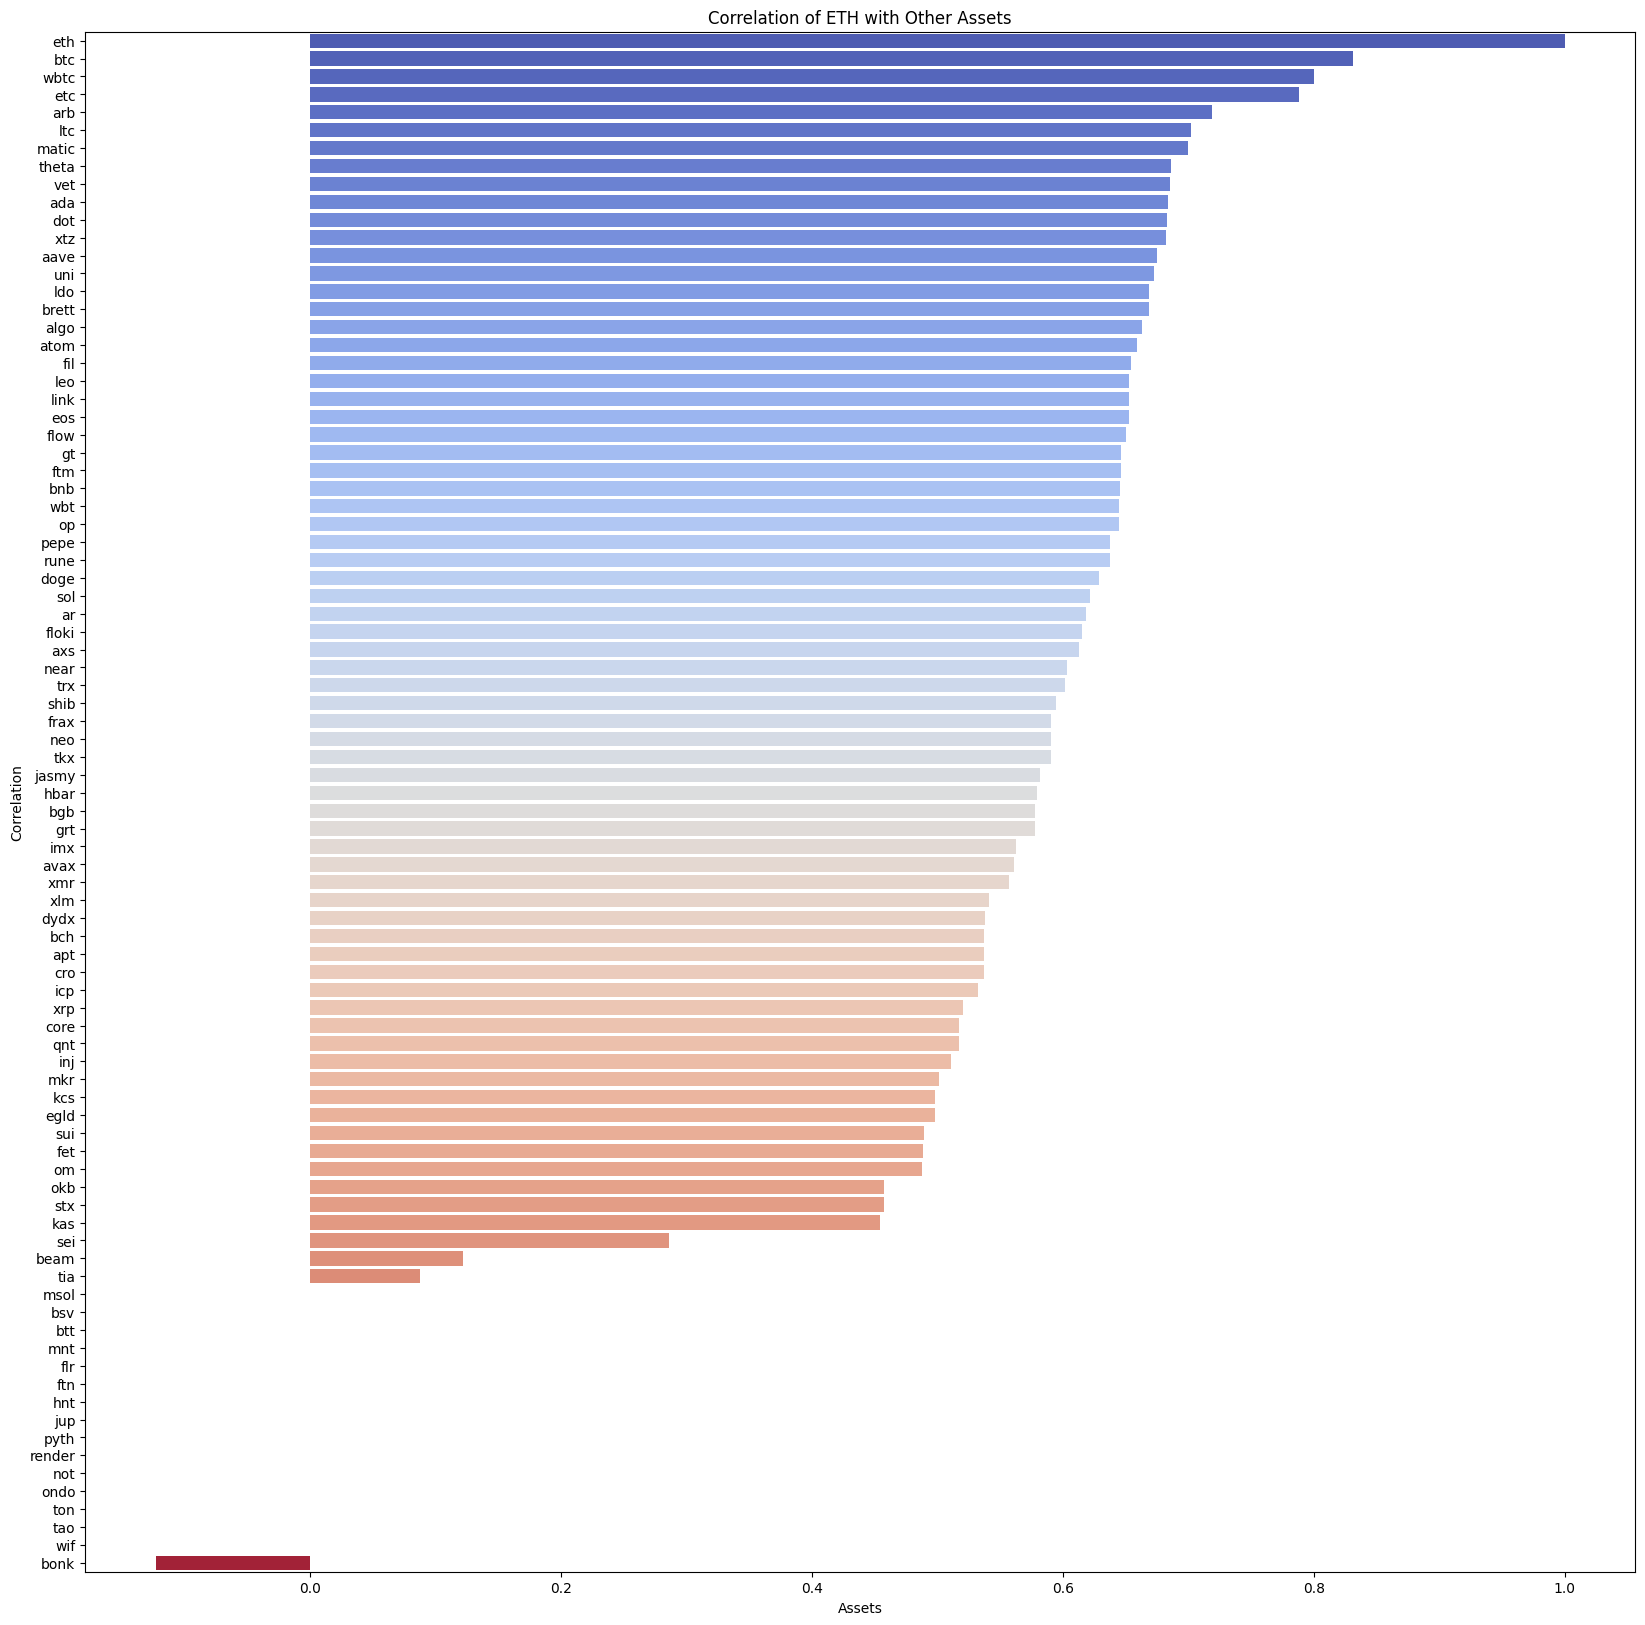

In [24]:
# Plot the correlation of 'ETH' with other assets
eth_correlation = correlation_matrix['eth'].sort_values(ascending=False)

# Plot the correlation of 'ETH' with other assets
plt.figure(figsize=(20, 20))
sns.barplot(x=eth_correlation.values, y=eth_correlation.index, palette='coolwarm')
plt.title('Correlation of ETH with Other Assets')
plt.xlabel('Assets')
plt.ylabel('Correlation')
plt.show()


In [15]:
sns.heatmap(.sort_values(ascending=False), annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})

TypeError: DataFrame.sort_values() missing 1 required positional argument: 'by'

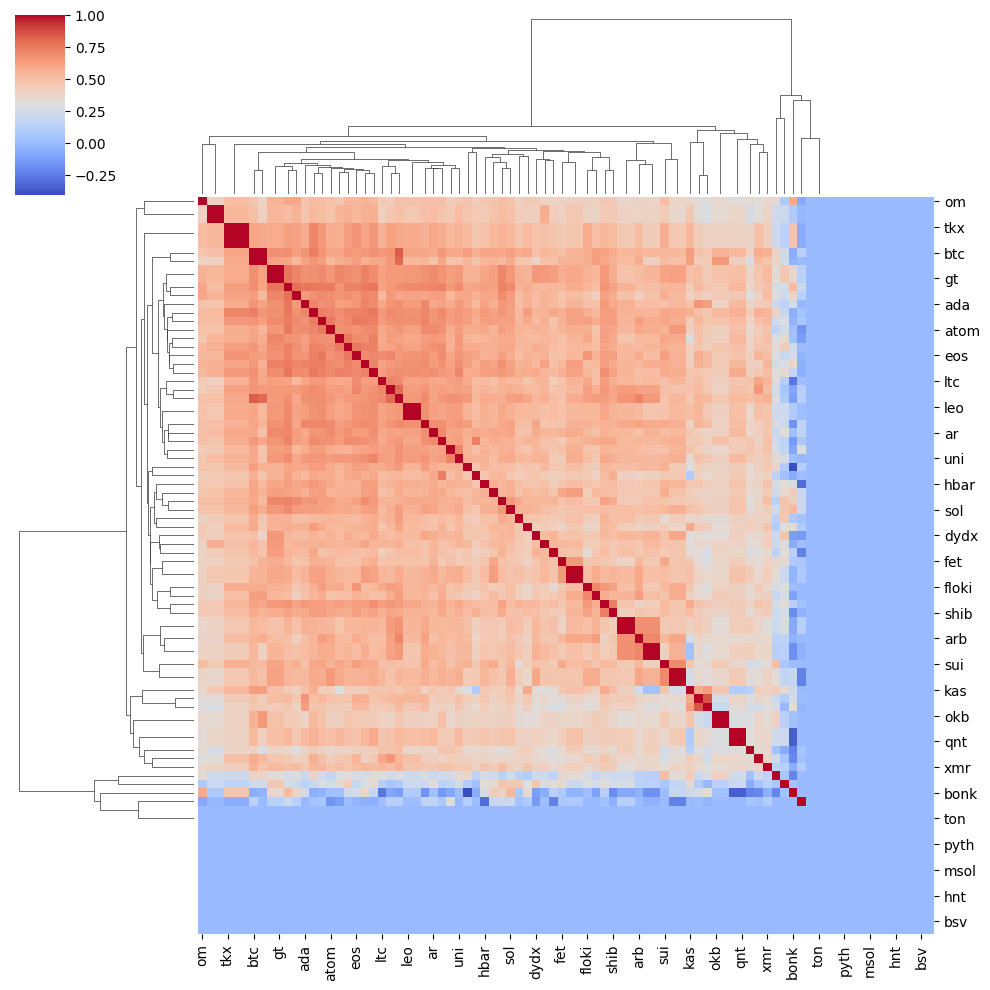

In [3]:
# Compute the correlation matrix
correlation_matrix = log_returns.corr()
correlation_matrix = correlation_matrix.fillna(0).sort_index(axis=0).sort_index(axis=1)
correlation_matrix
sns.clustermap(correlation_matrix, cmap='coolwarm')